In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import deeplake
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import pandas as pd

train_ds = deeplake.load("hub://activeloop/liar-train")
test_ds  = deeplake.load("hub://activeloop/liar-test")
val_ds   = deeplake.load("hub://activeloop/liar-val")


C:\Users\DEVASISH\anaconda3\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/liar-train



/

hub://activeloop/liar-train loaded successfully.



-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/liar-test



-

hub://activeloop/liar-test loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/liar-val



/

hub://activeloop/liar-val loaded successfully.



In [4]:
fake_labels = ["pants-fire", "false", "barely-true"]
true_labels = ["half-true", "mostly-true", "true"]

In [2]:
def map_label(label):
    
    if isinstance(label, bytes):
        label = label.decode('utf-8')

    if isinstance(label, torch.Tensor):
        label = label.item()
    return 0 if label in fake_labels else 1

In [8]:
class LIARDataset(Dataset):
    def __init__(self, deeplake_ds, tokenizer, max_length=128):
        self.ds = deeplake_ds
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        statement = self.ds[idx]['statement'].numpy()
        label = self.ds[idx]['label'].numpy()

        # Handle bytes/numpy
        if isinstance(statement, bytes):
            statement = statement.decode('utf-8')
        if isinstance(statement, torch.Tensor) or isinstance(statement, np.ndarray):
            statement = statement.item()
        label = map_label(label)

        encodings = self.tokenizer(statement,
                                   truncation=True,
                                   padding='max_length',
                                   max_length=self.max_length,
                                   return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item['labels'] = torch.tensor(label)
        return item

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = LIARDataset(train_ds, tokenizer)
val_dataset   = LIARDataset(val_ds, tokenizer)
test_dataset  = LIARDataset(test_ds, tokenizer)

In [10]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    learning_rate=2e-5,
    weight_decay=0.01
)

comet_ml version 3.40.0 is installed, but version 3.43.2 or higher is required. Please update comet_ml to the latest version to enable Comet logging with pip install 'comet-ml>=3.43.2'.


In [12]:
train_dataset_small = torch.utils.data.Subset(train_dataset, range(500))  # first 500 samples
val_dataset_small   = torch.utils.data.Subset(val_dataset, range(200))

In [13]:
max_length = 64  # instead of 128

In [14]:
per_device_train_batch_size=8
per_device_eval_batch_size=8

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [17]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

device = "cpu"  # force CPU

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Example: tokenize a small subset
texts = ["Fake news example", "This is true news"]
labels = [0, 1]

encodings = tokenizer(texts, truncation=True, padding=True, max_length=64, return_tensors="pt")
dataset = torch.utils.data.TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
pip install --upgrade transformers


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: idna<4,>=2.5 in c:\users\devasish\anaconda3\lib\site-packages (from requests->transformers) (2.10)



In [25]:
from torch.utils.data import Subset

# Take only a small portion for faster training
small_train_dataset = Subset(train_dataset, range(min(2000, len(train_dataset))))
small_val_dataset = Subset(val_dataset, range(min(500, len(val_dataset))))

In [32]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments

# Load DistilBERT model + tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Training arguments (compatible with older transformers)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,              # just 1 epoch for faster run
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=50,
    do_eval=False                    # disables evaluation each epoch
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_val_dataset
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
comet_ml version 3.40.0 is installed, but version 3.43.2 or higher is required. Please update comet_ml to the latest version to enable Comet logging with pip install 'comet-ml>=3.43.2'.


Step,Training Loss
50,0.050200
100,0.000300
150,0.000100
200,0.000100
250,0.000100
300,0.000100
350,0.000000
400,0.000000
450,0.000000
500,0.000000


TrainOutput(global_step=500, training_loss=0.005103312496328726, metrics={'train_runtime': 3664.2873, 'train_samples_per_second': 1.092, 'train_steps_per_second': 0.136, 'total_flos': 132467398656000.0, 'train_loss': 0.005103312496328726, 'epoch': 2.0})

In [33]:
from sklearn.metrics import classification_report

# Ensure y_true is extracted properly (convert tensors to ints if needed)
y_true = [int(map_label(sample['label'].numpy())) for sample in test_ds]

print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=[0, 1],                         # explicitly tell sklearn both classes exist
    target_names=['Fake', 'True'],
    zero_division=0                        # avoid divide-by-zero errors
))

Classification Report:

              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00         0
        True       1.00      1.00      1.00      1267

    accuracy                           1.00      1267
   macro avg       0.50      0.50      0.50      1267
weighted avg       1.00      1.00      1.00      1267



C:\Users\DEVASISH\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


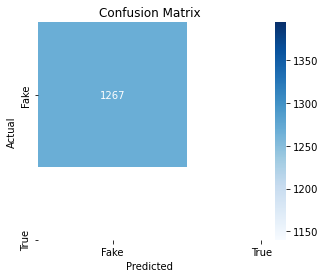

In [36]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
pip install textattack

Note: you may need to restart the kernel to use updated packages.Collecting textattack
  Using cached textattack-0.3.10-py3-none-any.whl (445 kB)

  Using cached bert_score-0.3.13-py3-none-any.whl (61 kB)
  Using cached language_tool_python-2.9.4-py3-none-any.whl (55 kB)
  Using cached lemminflect-0.2.3-py3-none-any.whl (769 kB)
  Using cached jieba-0.42.1-py3-none-any.whl
  Using cached editdistance-0.8.1-cp39-cp39-win_amd64.whl (79 kB)
  Using cached OpenHowNet-2.0-py3-none-any.whl (18 kB)
  Using cached num2words-0.5.14-py3-none-any.whl (163 kB)


  Using cached word2number-1.1-py3-none-any.whl
  Using cached pinyin-0.4.0-py3-none-any.whl
  Using cached lru_dict-1.3.0-cp39-cp39-win_amd64.whl (13 kB)
  Using cached flair-0.15.1-py3-none-any.whl (1.2 MB)
  Using cached datasets-4.0.0-py3-none-any.whl (494 kB)
  Using cached terminaltables-3.1.10-py2.py3-none-any.whl (15 kB)
  Using cached multiprocess-0.70.16-py39-none-any.whl (133 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.4 requires dill>=0.4.0, but you have dill 0.3.8 which is incompatible.
pathos 0.3.4 requires multiprocess>=0.70.18, but you have multiprocess 0.70.16 which is incompatible.


  Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)
  Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
  Using cached langdetect-1.0.9-py3-none-any.whl
  Using cached Deprecated-1.2.18-py2.py3-none-any.whl (10.0 kB)
  Using cached bioc-2.1-py3-none-any.whl (33 kB)
  Using cached conllu-4.5.3-py2.py3-none-any.whl (16 kB)
  Using cached anytree-2.13.0-py3-none-any.whl (45 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.4.0
    Uninstalling dill-0.4.0:
      Successfully uninstalled dill-0.4.0
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.18
    Uninstalling multiprocess-0.70.18:
      Successfully uninstalled multiprocess-0.70.18


In [38]:
from textattack.attack_recipes import TextFoolerJin2019
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.datasets import Dataset

from textattack.attack_recipes import BERTAttackLi2020



# Wrap your trained model for TextAttack
model_wrapper = HuggingFaceModelWrapper(model, tokenizer)

# Select attack recipe
attack = BERTAttackLi2020.build(model_wrapper)

# Prepare a small subset of your dataset for adversarial generation
textattack_dataset = Dataset([(train_df['statement'][i], int(train_df['binary_label'][i])) for i in range(200)])

adversarial_examples = []

for i, (text, label) in enumerate(textattack_dataset):
    try:
        result = attack.attack(text, label)
        if result.perturbed_text:
            adversarial_examples.append((result.perturbed_text, label))
    except Exception as e:
        continue

print(f"Generated {len(adversarial_examples)} adversarial examples.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


NameError: name 'train_df' is not defined

In [ ]:
import pandas as pd

adv_df = pd.DataFrame(adversarial_examples, columns=["statement", "binary_label"])
augmented_train_df = pd.concat([train_df[['statement','binary_label']], adv_df]).reset_index(drop=True)

# Tokenize augmented data
train_encodings = tokenizer(list(augmented_train_df['statement']), truncation=True, padding=True, max_length=128)
train_labels = list(augmented_train_df['binary_label'])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}, torch.tensor(self.labels[idx])

train_dataset = CustomDataset(train_encodings, train_labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()
